In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def plot_series(time, series, line="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], line, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [25]:
# add trend common patterns
def trend(time, slope=0):
    return slope * time

In [29]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

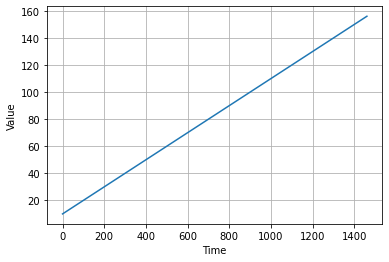

In [27]:
plot_series(time, series)

In [35]:
# seasonality
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

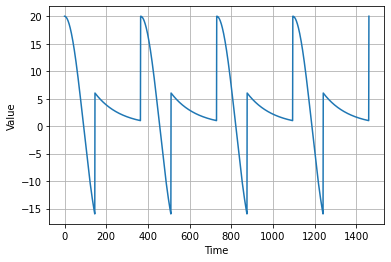

In [36]:
season_series = seasonality(time, period=365, amplitude=20)
plot_series(time, season_series)

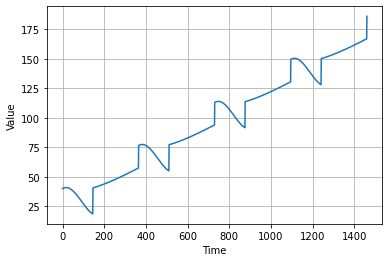

In [37]:
# time series with both trend and seasonality
slope = 0.05
series = baseline + series + season_series

plot_series(time, series)

In [38]:
# noise
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

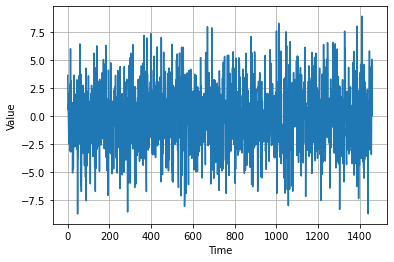

In [39]:
noise = white_noise(time, noise_level=3, seed=20902490)

plot_series(time, noise)

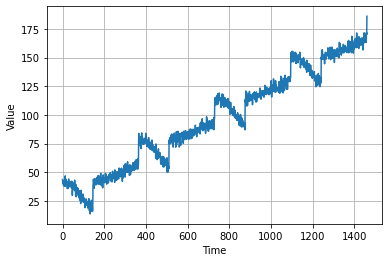

In [40]:
# series with seasonality, noise, trend
series += noise
plot_series(time, series)

In [41]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

In [54]:
naive_forecast = series[split_time - 1:-1] # lags 1 step behind the series

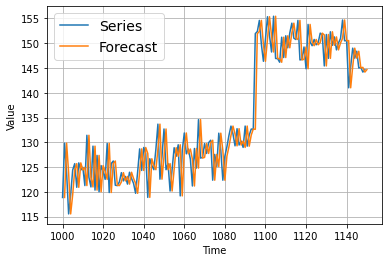

In [58]:
plot_series(time_valid, series_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [61]:
errors = naive_forecast - series_valid
abs_errors = np.abs(errors)
abs_errors.mean()

3.619533420642843

In [64]:
naive_mae = tf.keras.metrics.mean_absolute_error(series_valid, naive_forecast).numpy()

In [62]:
import tensorflow as tf

In [65]:
# moving average
def moving_average_forecast_slow(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time: time + window_size].mean())
    return np.array(forecast)

In [69]:
len(series)

1461

In [68]:
len(np.cumsum(series))

1461

In [75]:
# a faster implementation of moving_average_forecast
def moving_average_forecast(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1: -1] / window_size

In [76]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

In [77]:
len(moving_avg)

461

In [80]:
len(series_valid)

461

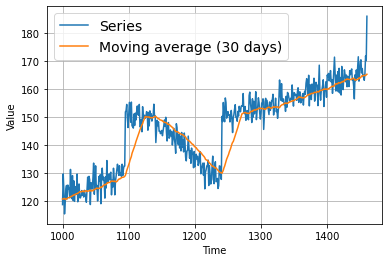

In [82]:
plot_series(time_valid, series_valid, label = "Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [84]:
tf.keras.metrics.mean_absolute_error(series_valid, moving_avg).numpy()

4.050423430651278

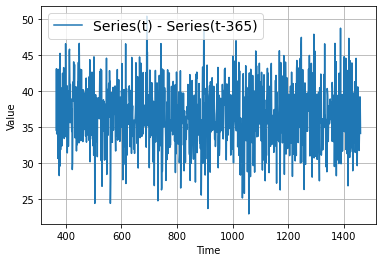

In [85]:
# remove the seasonality
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plot_series(diff_time, diff_series, label = "Series(t) - Series(t-365)")

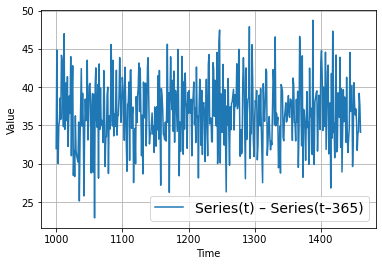

In [86]:
# validation period
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")

In [89]:
remove_seasonality_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30: ]

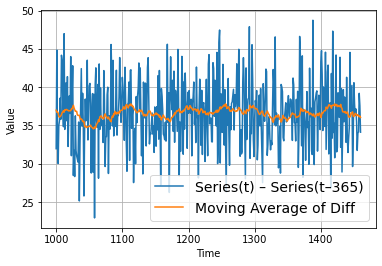

In [90]:
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, remove_seasonality_moving_avg, label="Moving Average of Diff")

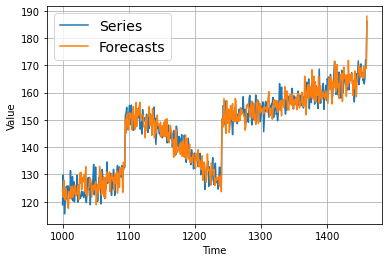

In [91]:
# bring back the seasonality
moving_avg = series[split_time - 365: -365] + remove_seasonality_moving_avg

plot_series(time_valid, series_valid, label="Series")
plot_series(time_valid, moving_avg, label="Forecasts")

In [94]:
tf.keras.metrics.mean_absolute_error(series_valid, moving_avg).numpy()

3.5558669500590288

In [95]:
len(moving_avg)

461

In [101]:
# averaging on the past values to remove noise
past_val_moving_avg = moving_average_forecast(series, 30)[split_time - 30 - 365: -365]
len(past_val_moving_avg)

461

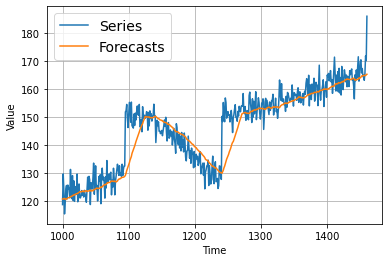

In [103]:
moving_avg_plus_smooth_past = past_val_moving_avg + remove_seasonality_moving_avg
plot_series(time_valid, series_valid, label="Series")
plot_series(time_valid, moving_avg_plus_smooth_past, label="Forecasts")